### IMPORT LIBS

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import random
import numpy as np
import scipy.io as scio
import pandas as pd
import os
import collections
from matplotlib import pyplot as plt

from keras import optimizers
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### PATH

In [2]:
base_path = '/home/wzx/ECGAI/EXP1/1D_CNN'

dataset_path =  '/home/wzx/ECGAI/EXP1/Dataset/' # Training data

### PLOT SETTING

In [3]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

### FUNCTIONS

### LAYERS

In [4]:
def nn_base(Unit, Kernel, Conv_Stride, Maxpool_Stride, input_tensor = None):
    
    input_shape = (None, 3)

    ecg_input = input_tensor

    bn_axis = 3

    # nn_base
    x = Conv1D(filters = Unit, kernel_size = Kernel, padding = 'same', strides = Conv_Stride, activation = 'relu', 
               data_format='channels_last')(ecg_input)
    
    x = BatchNormalization()(x)
    
    x = MaxPooling1D(pool_size = 2, strides = Maxpool_Stride, padding = 'same', 
                     data_format='channels_last')(x)

    return x

In [5]:
def classifier_layer(base_layer, dropout_rate = 0.1, ClassesNum = 17):
    
    # classifier layers
    x = Conv1D(filters = 32, kernel_size = 10, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D1', data_format='channels_last')(base_layer)
    
    x = Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu', 
               strides = 2, name = 'classifier_layer_Conv1D2', data_format='channels_last')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D1', data_format='channels_last')(x)
    
    x = Conv1D(filters = 256, kernel_size = 15, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D3', data_format='channels_last')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D2', data_format='channels_last')(x)
    
    x = Conv1D(filters = 512, kernel_size = 5, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D4', data_format='channels_last')(x)
    
    x = Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D5', data_format='channels_last')(x)
    
    
    x = Flatten(name = 'classifier_layer_Flatten')(x)
    x = Dense(units = 512, activation = 'relu', name = 'classifier_layer_Dense1')(x)
    x = Dropout(rate = dropout_rate, name = 'classifier_layer_Dropout')(x)
    x = Dense(units = ClassesNum, activation = 'softmax', name = 'classifier_layer_Dense2')(x)
    
    return x

### DATA PROCESSING

In [6]:
# Variables

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num

### START TRAINING

In [7]:
# list -> arr
X=np.array(X)
y=np.array(y)

print("total num of training data : ", len(X))

# get X_train, X_test, y_train, y_test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

total num of training data :  1000
X_train :  800
X_test  :  200
y_train :  Counter({0: 231, 3: 110, 6: 101, 13: 85, 1: 56, 14: 47, 7: 42, 16: 34, 2: 14, 5: 14, 8: 12, 4: 10, 11: 9, 10: 9, 15: 9, 12: 9, 9: 8})
y_test  :  Counter({0: 52, 6: 32, 3: 25, 13: 18, 14: 15, 7: 13, 16: 11, 1: 10, 5: 7, 2: 6, 4: 3, 12: 2, 9: 2, 8: 1, 15: 1, 10: 1, 11: 1})
shape of X_train :  (3600,)
shape of y_train :  (800,)
shape of X_test :  (200, 3600)
shape of y_test :  (200,)


### BUILD MODEL_SEQ

In [8]:
'''
model_all = Sequential()
model_all.add(Conv1D(128, 50, padding = 'same', activation='relu', strides = 3,
                     input_shape=(3600,1), data_format='channels_last'))
model_all.add(BatchNormalization())
model_all.add(MaxPooling1D(3, padding = 'same', data_format='channels_last'))

model_all.add(Conv1D(32, 7, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(BatchNormalization())
model_all.add(MaxPooling1D(2, padding = 'same', data_format='channels_last'))

model_all.add(Conv1D(32, 10, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(Conv1D(128, 5, padding = 'same', activation='relu', strides = 2, data_format='channels_last'))
model_all.add(MaxPooling1D(2,padding = 'same', data_format='channels_last'))

model_all.add(Conv1D(256, 15, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(MaxPooling1D(2, padding = 'same', data_format='channels_last')) 

model_all.add(Conv1D(512, 5, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(Conv1D(128, 3, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))
model_all.add(Flatten(data_format='channels_last'))

model_all.add(Dense(512, activation='relu'))
model_all.add(Dropout(0.1))
model_all.add(Dense(ClassesNum, activation='softmax'))

print(model_all.summary())
'''

"\nmodel_all = Sequential()\nmodel_all.add(Conv1D(128, 50, padding = 'same', activation='relu', strides = 3,\n                     input_shape=(3600,1), data_format='channels_last'))\nmodel_all.add(BatchNormalization())\nmodel_all.add(MaxPooling1D(3, padding = 'same', data_format='channels_last'))\n\nmodel_all.add(Conv1D(32, 7, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))\nmodel_all.add(BatchNormalization())\nmodel_all.add(MaxPooling1D(2, padding = 'same', data_format='channels_last'))\n\nmodel_all.add(Conv1D(32, 10, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))\nmodel_all.add(Conv1D(128, 5, padding = 'same', activation='relu', strides = 2, data_format='channels_last'))\nmodel_all.add(MaxPooling1D(2,padding = 'same', data_format='channels_last'))\n\nmodel_all.add(Conv1D(256, 15, padding = 'same', activation='relu', strides = 1, data_format='channels_last'))\nmodel_all.add(MaxPooling1D(2, padding = 'same', data_format=

### BUILD MODEL_MOD

In [9]:
input_ecg = Input(shape=(3600,1))
x = nn_base(128, 50, Conv_Stride = 3, Maxpool_Stride = 3, input_tensor = input_ecg)
x = nn_base(32, 7, Conv_Stride = 1, Maxpool_Stride = 2, input_tensor = x)
output_ecg = classifier_layer(x, dropout_rate = 0.1, ClassesNum = 17)
model_m = Model(input_ecg, output_ecg)
print(model_m.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3600, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1200, 128)         6528      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1200, 128)         512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 400, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 32)           28704     
_________________________________________________________________
batch_normalization_2 (Batch (None, 400, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 200, 32)           0   

### SETTING OPTIMIZERS & COMPILE

In [10]:
# setting optimizers & compile
optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# model_all.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# expand X_train dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.reshape(X_test, (np.shape(X_test)[0], np.shape(X_test)[1], 1))
# Y : int -> binary (one-hot)
y_train = to_categorical(y_train,num_classes = ClassesNum)
y_test = to_categorical(y_test,num_classes = ClassesNum)

display(np.shape(X_train))

(800, 3600, 1)

### TRAINING 

In [11]:
BATCH_SIZE = 16
EPOCHS = 50
# history = model_all.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)
history = model_m.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)

Epoch 1/50
800/800 [==============================] - 11s 13ms/step - loss: 2.4053 - accuracy: 0.2525
Epoch 2/50
800/800 [==============================] - 10s 12ms/step - loss: 2.0671 - accuracy: 0.3462
Epoch 3/50
800/800 [==============================] - 10s 12ms/step - loss: 1.7505 - accuracy: 0.4462
Epoch 4/50
800/800 [==============================] - 10s 13ms/step - loss: 1.3684 - accuracy: 0.5838
Epoch 5/50
800/800 [==============================] - 11s 13ms/step - loss: 1.1165 - accuracy: 0.6550
Epoch 6/50
800/800 [==============================] - 11s 13ms/step - loss: 0.7780 - accuracy: 0.7688
Epoch 7/50
800/800 [==============================] - 11s 13ms/step - loss: 0.5790 - accuracy: 0.8163
Epoch 8/50
800/800 [==============================] - 11s 13ms/step - loss: 0.4882 - accuracy: 0.8562
Epoch 9/50
800/800 [==============================] - 11s 14ms/step - loss: 0.4032 - accuracy: 0.8725
Epoch 10/50
800/800 [==============================] - 11s 14ms/step - loss: 0.296

### PRINT ACC&LOSS 

In [12]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy'])
[2.4052612733840943, 2.0671247100830077, 1.7505290508270264, 1.368449856042862, 1.1165424060821534, 0.77798822671175, 0.5790209266543388, 0.48818119704723356, 0.4032498310506344, 0.2966289259493351, 0.2831666901893914, 0.2714690057374537, 0.2673370941262692, 0.25708476711064576, 0.14417970392853022, 0.04665114414470736, 0.0463705631873745, 0.08078337466315133, 0.1261724455934018, 0.0710149673822525, 0.22737072023563087, 0.39606689620763064, 0.14223173876700457, 0.2379641355376225, 0.1293224756329437, 0.05838865383499069, 0.48173133804579266, 0.20888633601367473, 0.20936205350153614, 0.10106931150570744, 0.12212980563999735, 0.08314624222926796, 0.06392930425005033, 0.025383378592305234, 0.03613957307529972, 0.06184293781199813, 0.04226068708572541, 0.03499240073808778, 0.05630163647394511, 0.015120392870096566, 0.001800203937474123, 0.00016115699926047, 0.00016508265193465377, 5.51621229683974e-05, 4.841906668957563e-05, 5.677955408543767e-05, 3.92421919

### PRINT PLOT 

Text(0.5, 1.0, 'acc')

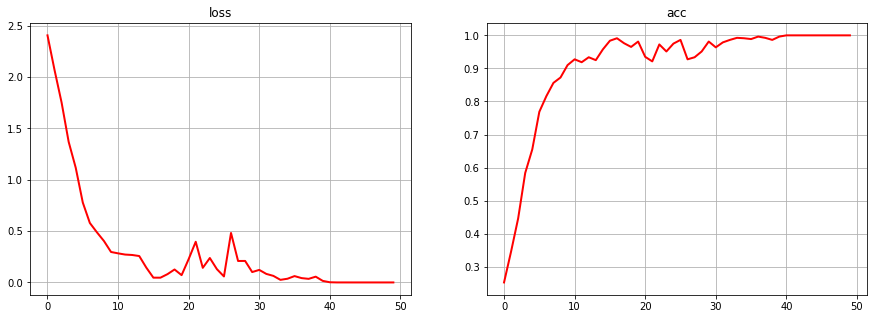

In [13]:
# put into df
record_arr = np.array([history.history['loss'][0], history.history['accuracy'][0]])
for i in range(1, EPOCHS):
    new_row = np.array([history.history['loss'][i], history.history['accuracy'][i]])
    record_arr = np.row_stack((record_arr, new_row))
    
record_df = pd.DataFrame(record_arr, columns=["loss", "acc"])

#print curve
plt.subplot(1,2,1)
plt.plot(np.arange(0, EPOCHS), record_df["loss"], 'r')
plt.title('loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, EPOCHS), record_df["acc"], 'r')
plt.title('acc')

### VAL ACC LOSS 

In [14]:
# val_loss_acc = model_all.evaluate(X_test, y_test, batch_size=100)
val_loss_acc = model_m.evaluate(X_test, y_test, batch_size = 16)
print("loss of val : ", val_loss_acc[0])
print("acc of val : ", val_loss_acc[1])

200/200 [==============================] - 1s 3ms/step
loss of val :  0.7355309784412378
acc of val :  0.9150000214576721


### PREDICT 

In [15]:
# predictions = model_all.predict(X_test)
predictions = model_m.predict(X_test)
display(predictions)

array([[1.4513188e-19, 4.3085264e-19, 1.7501438e-34, ..., 1.6102507e-17,
        2.9876611e-21, 1.2744028e-22],
       [7.9946536e-01, 1.2595058e-06, 2.4456509e-20, ..., 1.8260224e-12,
        5.6168919e-19, 3.2707894e-16],
       [9.9996686e-01, 2.7398326e-09, 6.8875079e-12, ..., 2.4115113e-12,
        4.0501906e-13, 2.4898645e-16],
       ...,
       [9.9432654e-08, 1.9557793e-09, 4.7123874e-09, ..., 4.5037151e-13,
        2.0587726e-16, 1.2933056e-16],
       [1.0000000e+00, 1.6102940e-09, 2.6489277e-16, ..., 1.0764033e-12,
        9.2355801e-17, 3.7971592e-19],
       [3.2180862e-19, 3.2672121e-15, 5.5403745e-24, ..., 3.9494712e-21,
        3.9473195e-20, 5.6691361e-19]], dtype=float32)